In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from time import time
from matplotlib import pyplot as plt

# import sklearn for accuracy, F1 score and AUC calcs as per update 24/04/2021
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
# Load data
test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')
train_data = np.load('train_data.npy')
train_label = np.load('train_label.npy')

# Output training data to one hot encoding
nb_classes = 10
targets = train_label.reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]
one_hot_targets_test = np.eye(nb_classes)[test_label]

In [3]:
#Function outputing the run time in minutes & secs
def timeValue(time_input):
    if time_input < 60:
        time_output = str(round(time_input, 1)) + ' seconds'
    else:
        time_output = str(int(time_input // 60)) + ' minutes, ' + str(round(time_input % 60, 1) - 1) + ' seconds'
    return time_output

In [4]:
# Min-max normalization for the test and train data sets since input data is not norm distributed
train_data = (train_data - np.amin(train_data,axis=0, keepdims=True))\
            / (np.amax(train_data,axis=0, keepdims=True)- np.amin(train_data,axis=0, keepdims=True))
test_data = (test_data - np.amin(test_data,axis=0, keepdims=True))\
            / (np.amax(test_data,axis=0, keepdims=True)- np.amin(test_data,axis=0, keepdims=True))

In [5]:
# Activation Functions
class Activation(object):
    
    # Tanh activation function
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2
    
    # Logistic/sigmoid activation function
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        return  a * (1 - a )
    
    # ReLU activation function
    # For ReLU and Leaky ReLU, the derivatrive is undefined at a=0, but in practise this is usually ignored
    def __relu(self, x):
        return np.maximum(0, x)
    
    def __relu_deriv(self, a): 
        return np.where(a <= 0, 0, 1)
    
    # Leaky ReLU activation function
    # For Leaky ReLU the convetion is to use 0.01 for the gradient.
    def __leaky_relu(self, x):
        return np.maximum(0.01* x , x)
    
    def __leaky_relu_deriv(self, a): 
        return np.where(a <=0, 0.01, 1)
    
    # softmax activation function
    def __softmax(self, x):
        x = x - np.max(x)
        return np.exp(x) / (np.sum(np.exp(x) + 1e-15, axis=0))    

    def __softmax_deriv(self, a):
        return a * (1 - a)
    
    # activation function class
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
            
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
    
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv
        
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

In [6]:
# Batch normalisation forward pass
def batch_norm_forward_pass(x, beta, gamma, step_type, running_mean=None, running_var=None, epsilon=1e-5):
    if step_type == 'train':
        mean = x.mean(axis=0)
        var = x.var(axis=0)
        std = np.sqrt(var + epsilon)

        x_centered = x - mean
        x_norm = x_centered / std
        out = gamma * x_norm + beta

        return out, mean, var, (x_norm, x_centered, gamma, std)
    
    std = np.sqrt(running_var + epsilon)
    x_centered = x - running_mean
    x_norm = x_centered / std
    out = gamma * x_norm + beta
    
    return out
    
# Batch normalisation backward pass
def batch_norm_backward_pass(dx, backprop_data):
    x_norm, x_centered, gamma, std = backprop_data
    
    dgamma = (dx * x_norm).sum(axis=0)
    dbeta = dx.sum(axis=0)
    dx_norm = dx * gamma
    dx = 1 / dx.shape[0] / std * (dx.shape[0] * dx_norm - dx_norm.sum(axis=0) - x_norm * (dx_norm * x_norm).sum(axis=0))
    
    return dx, dbeta, dgamma

In [7]:
# Hidden Layer function
class HiddenLayer(object):    
    
    def __init__(self, n_in, n_out, activation_last_layer='tanh',activation='tanh', W=None, b=None):

        self.input = None
    
        self.activation = None
        if activation:
            self.activation = Activation(activation).f
        
        # Activation deriv of last layer
        self.activation_deriv = None
        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv
        
        # Weight initialisation for relu and leaky relu is He     
        if activation == 'relu' or activation == 'leaky_relu':
            self.W = np.random.uniform(
                low =- np.sqrt(2. / n_in),
                high = np.sqrt(2. / n_in),
                size = (n_in, n_out)
            ) 
        else:
            self.W = np.random.uniform(
                low =- np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)
            )
            
        # Weight initialisation for logistic is 4x xavier   
        if activation == 'logistic':
            self.W *= 4
                    
        # Set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # Set the size of weight grad
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # Set the size of the accum grad for momentum calc
        self.accgrad_W = np.zeros(self.W.shape)
        self.accgrad_b = np.zeros(self.b.shape)
        
        # Set the size of the beta, gamma, running mean/var, backprop_data for the batch normalisation
        self.beta = np.random.randn(n_out,)
        self.gamma = np.random.randn(n_out,)
        self.running_mean = np.zeros(n_out,)
        self.running_var = np.zeros(n_out,)
        self.backprop_data = None
    
    # Forward pass for each training epoch
    def forward(self, input, step_type, batch_norm, momentum=None):
        lin_output = np.dot(input, self.W) + self.b
        
        if batch_norm:
            if step_type == 'train':
                lin_output, mean, var, self.backprop_data = batch_norm_forward_pass(lin_output, self.beta, self.gamma, 'train')

                self.running_mean = momentum * self.running_mean + (1 - momentum) * mean
                self.running_var = momentum * self.running_var + (1 - momentum) * var
            elif step_type == 'test':
                lin_output = batch_norm_forward_pass(lin_output, self.beta, self.gamma, 'test', self.running_mean, self.running_var)
            
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        
        self.input=input
        
        return self.output
    
    # Backward pass for each training epoch
    def backward(self, delta, batch_norm, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.dot(np.ones((self.input.shape[0], 1)).T, delta)

        if self.activation_deriv:
            if batch_norm:
                delta = delta * self.activation_deriv(self.output)
                delta, dbeta, dgamma = batch_norm_backward_pass(delta, self.backprop_data)
                delta = delta.dot(self.W.T)
                self.gamma += dgamma
                self.beta += dbeta
            else:
                delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

In [8]:
# MLP Model
class MLP:

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','tanh'], batch_norm= False):
      
        # initialize layers
        self.layers = []
        self.params = []
        
        # initialize dropout & running mean/var (for batch norm)
        self.dropout = 1
        self.running_mean = None
        self.running_var = None
        self.epochs = None
        self.batch_size = None
        
        self.activation = activation
        for i in range(len(layers)-1):
            if batch_norm:
                self.layers.append(HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])) 
            else:
                self.layers.append(HiddenLayer(layers[i], layers[i+1], activation[i - 1], activation[i]))

    # forward pass the information through the layers and out the results of final output layer
    def forward(self, input, step_type, batch_norm, momentum=None):
        for ctr, layer in enumerate(self.layers):
            output = layer.forward(input, step_type, batch_norm, momentum)
            
            if 1 <= ctr <= len(self.layers) - 2 and step_type == 'train':
                output = output * np.atleast_2d(np.random.binomial(1, self.dropout, output.shape[0])).T
            elif step_type == 'test':
                output = output * self.dropout
            input = output
        return output

    # Cross Entropy loss function with softmax
    def criterion_softmax_cross(self, y, y_hat):
        loss = np.mean(-y * np.log(y_hat + 1e-15))
        #calculate the delta of the output layer (simplified due to softmax + CEL combo)
        delta = y_hat - y
        # return loss and delta
        return loss, delta 

    # backward pass  
    def backward(self, delta, batch_norm):
        delta = self.layers[-1].backward(delta, batch_norm, output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta = layer.backward(delta, batch_norm)

    # update the network weights after backward using SGD with momentum + engineers decay method
    def update(self,lr, mom, dec):
        for layer in self.layers:
            
            # calc the accumulated gradient
            layer.accgrad_W = mom * layer.accgrad_W + lr * layer.grad_W
            layer.accgrad_W = mom * layer.accgrad_W + lr * layer.grad_b
            
            # Update the weights with accum gradient & decay
            layer.W = layer.W - layer.accgrad_W * dec
            layer.b = layer.b - layer.accgrad_b * dec
    
    # define the training function
    def fit(self, X, y, X_test, y_test, batch_size, batch_norm=False, learning_rate=0.1, momentum = 0.9, decay = 0.98, epochs=100, dropout=1):
        """
        :param X: Input data or features
        :param y: Input targets
        :batch_size: Size of batch for mini-batch training
        :bath_norm: True/false for turning on/off batch normalisation
        :learning_rate: Defines the speed of learning
        :momentum: Momentum terma (gamma) 
        :decay: Engineers weight decay method
        :epochs: Number of times the dataset is presented to the network for learning
        :dropout: Nodes are droppedout with a probability of p (dropout)
        """
        
        # set epsilon to small value for batch normalisation 
        epsilon = 1e-5
        
        X = np.array(X)
        y = np.array(y)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        to_return = [0] * epochs
        num_batches = int(X.shape[0] / batch_size)
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size

        for k in range(epochs):
            loss = np.zeros(num_batches)
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
    
            X = X[indices]
            y = y[indices]
    
            for it in range(num_batches):
                # forward pass
                y_hat = self.forward(X[it * batch_size: (it + 1) * batch_size], 'train', batch_norm, momentum)

                # backward pass
                loss[it], delta = self.criterion_softmax_cross(y[it * batch_size: (it + 1) * batch_size], y_hat)
                self.backward(delta / batch_size, batch_norm)
                y

                # update
                self.update(learning_rate, momentum, decay)
            
            # Train performance metrics
            pred = self.predict(X, y, 'train', batch_norm)
            target = np.squeeze(np.argmax(y, axis=1))

            # Accuracy, F1 Score, AUC Score
            train_accuracy = accuracy_score(target, pred)
            f1 = f1_score(target, pred, average='micro')
            fpr, tpr, thresholds = metrics.roc_curve(target, pred, pos_label=2)
            AUC = metrics.auc(fpr, tpr)
            
            # Test performance metrics
            test_results = self.predict(X_test, y_test, 'test', batch_norm)
            test_pred = test_results[0]
            test_target = np.squeeze(np.argmax(np.squeeze(y_test), axis=1))
            test_loss = test_results[1]
            
            # Accuracy, F1 Score, AUC Score
            test_accuracy = accuracy_score(test_target, test_pred)
            test_f1 = f1_score(test_target, test_pred, average='micro')
            fpr, tpr, thresholds = metrics.roc_curve(test_target, test_pred, pos_label=2)
            test_AUC = metrics.auc(fpr, tpr)
            
            # Train & Test Metrics
            train_metrics = np.mean(loss), 100 * train_accuracy, f1, AUC
            test_metrics = np.mean(test_loss), 100 * test_accuracy, test_f1, test_AUC
            
            # Return Train & Test Metrics
            to_return[k] = train_metrics, test_metrics
            
            # Print performance for each epoch
            print(f'Epoch {k + 1}')
            print(f'Training : Loss = {train_metrics[0]:.4f}, Accuracy = {train_metrics[1]:.2f}%, f1_score = {f1:.4f}, AUC = {AUC:.4f}')
            print(f'Test     : Loss = {test_metrics[0]:.4f}, Accuracy = {test_metrics[1]:.2f}%, f1_score = {test_f1:.4f}, AUC = {test_AUC:.4f}\n')
        
        return np.array(to_return)

    # define the prediction function
    def predict(self, X, y, data_type, batch_norm):
        X = np.array(X)
        output = self.forward(X, 'test', batch_norm)

        if data_type == 'test':
            test_loss = self.criterion_softmax_cross(y, output)[0]

        output = np.squeeze(np.argmax(output, axis=1))

        if data_type == 'test':
            return np.array(output), test_loss

        return np.array(output)

In [9]:
# Record start time
start_time = time()

batch_norm = False

### Try different MLP models
nn = MLP([128, 90, 90, 10], [None, 'relu', 'relu','softmax'], batch_norm=batch_norm)

input_data = train_data
output_data = one_hot_targets

### Try different learning rate and e
CE = nn.fit(input_data, output_data, test_data, one_hot_targets_test, batch_size=1024, batch_norm=batch_norm, learning_rate=0.001, momentum = 0.9, decay = 0.98, epochs=150, dropout=1)
# print('loss:%f'%CE[-1])

# Record runtime
run_time = timeValue(time() - start_time)
print(f'Run Time {run_time}')

Epoch 1
Training : Loss = 0.8409, Accuracy = 9.61%, f1_score = 0.0961, AUC = 0.4994
Test     : Loss = 0.3210, Accuracy = 8.53%, f1_score = 0.0853, AUC = 0.5491

Epoch 2
Training : Loss = 0.2607, Accuracy = 9.67%, f1_score = 0.0967, AUC = 0.5050
Test     : Loss = 0.2682, Accuracy = 8.82%, f1_score = 0.0882, AUC = 0.5425

Epoch 3
Training : Loss = 0.2595, Accuracy = 9.78%, f1_score = 0.0978, AUC = 0.5034
Test     : Loss = 0.2687, Accuracy = 8.82%, f1_score = 0.0882, AUC = 0.5510

Epoch 4
Training : Loss = 0.2580, Accuracy = 9.76%, f1_score = 0.0976, AUC = 0.5054
Test     : Loss = 0.2698, Accuracy = 8.71%, f1_score = 0.0871, AUC = 0.5469

Epoch 5
Training : Loss = 0.2576, Accuracy = 10.05%, f1_score = 0.1005, AUC = 0.5010
Test     : Loss = 0.2680, Accuracy = 8.97%, f1_score = 0.0897, AUC = 0.5456

Epoch 6
Training : Loss = 0.2556, Accuracy = 10.06%, f1_score = 0.1006, AUC = 0.5068
Test     : Loss = 0.2702, Accuracy = 8.86%, f1_score = 0.0886, AUC = 0.5517

Epoch 7
Training : Loss = 0.2532

Epoch 52
Training : Loss = 0.2356, Accuracy = 13.33%, f1_score = 0.1333, AUC = 0.5018
Test     : Loss = 0.2588, Accuracy = 11.15%, f1_score = 0.1115, AUC = 0.5184

Epoch 53
Training : Loss = 0.2352, Accuracy = 13.52%, f1_score = 0.1352, AUC = 0.5012
Test     : Loss = 0.2573, Accuracy = 11.26%, f1_score = 0.1126, AUC = 0.5220

Epoch 54
Training : Loss = 0.2351, Accuracy = 13.54%, f1_score = 0.1354, AUC = 0.5045
Test     : Loss = 0.2564, Accuracy = 11.45%, f1_score = 0.1145, AUC = 0.5180

Epoch 55
Training : Loss = 0.2349, Accuracy = 13.54%, f1_score = 0.1354, AUC = 0.5025
Test     : Loss = 0.2578, Accuracy = 11.56%, f1_score = 0.1156, AUC = 0.5120

Epoch 56
Training : Loss = 0.2347, Accuracy = 13.67%, f1_score = 0.1367, AUC = 0.5017
Test     : Loss = 0.2563, Accuracy = 11.66%, f1_score = 0.1166, AUC = 0.5129

Epoch 57
Training : Loss = 0.2346, Accuracy = 13.71%, f1_score = 0.1371, AUC = 0.5015
Test     : Loss = 0.2573, Accuracy = 11.39%, f1_score = 0.1139, AUC = 0.5132

Epoch 58
Trainin

Epoch 102
Training : Loss = 0.2287, Accuracy = 16.32%, f1_score = 0.1632, AUC = 0.4968
Test     : Loss = 0.2506, Accuracy = 13.74%, f1_score = 0.1374, AUC = 0.4947

Epoch 103
Training : Loss = 0.2284, Accuracy = 16.37%, f1_score = 0.1637, AUC = 0.4922
Test     : Loss = 0.2521, Accuracy = 13.60%, f1_score = 0.1360, AUC = 0.5012

Epoch 104
Training : Loss = 0.2282, Accuracy = 16.33%, f1_score = 0.1633, AUC = 0.4957
Test     : Loss = 0.2519, Accuracy = 13.86%, f1_score = 0.1386, AUC = 0.4987

Epoch 105
Training : Loss = 0.2282, Accuracy = 16.56%, f1_score = 0.1656, AUC = 0.4895
Test     : Loss = 0.2513, Accuracy = 13.84%, f1_score = 0.1384, AUC = 0.4940

Epoch 106
Training : Loss = 0.2280, Accuracy = 16.51%, f1_score = 0.1651, AUC = 0.4951
Test     : Loss = 0.2518, Accuracy = 14.02%, f1_score = 0.1402, AUC = 0.4953

Epoch 107
Training : Loss = 0.2281, Accuracy = 16.64%, f1_score = 0.1664, AUC = 0.4891
Test     : Loss = 0.2504, Accuracy = 14.09%, f1_score = 0.1409, AUC = 0.4919

Epoch 108


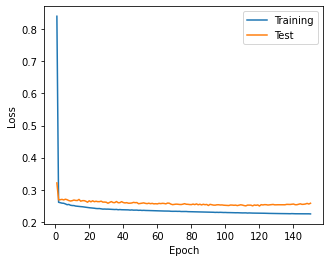

In [10]:
# Loss Plot
loss_y1 = CE[:, 0, 0]
loss_y2 = CE[:, 1, 0]
loss_x = np.arange(1, len(CE) + 1)

pl.figure(figsize=(5,4))
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.plot(loss_x, loss_y1, label="Training")
pl.plot(loss_x, loss_y2, label="Test")
pl.legend()
#pl.savefig('Half_Epoch_Loss.png')
pl.show()


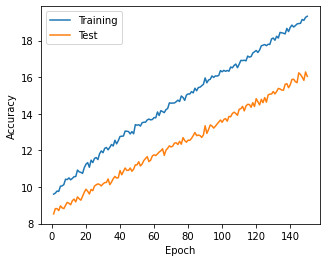

In [11]:
# Accuracy Plot
acc_y1 = CE[:, 0, 1]
acc_y2 = CE[:, 1, 1]
acc_x = np.arange(1, len(CE) + 1)

pl.figure(figsize=(5,4))
pl.xlabel('Epoch')
pl.ylabel('Accuracy')
pl.plot(acc_x, acc_y1, label="Training")
pl.plot(acc_x, acc_y2, label="Test")
pl.legend()
#pl.savefig('Half_Epoch_Accuracy.png')
pl.show()
